In [10]:
# notebook ran in gcp, not local

In [9]:
%%bigquery
CREATE OR REPLACE MODEL `hca-hvu7470-202504041334-sbx.scheduler.daily_bike_demand_forecast`
OPTIONS(
  model_type = 'ARIMA_PLUS',
  time_series_timestamp_col = 'trip_date',
  time_series_data_col = 'num_trips',
  time_series_id_col = 'start_station_id',
  holiday_region = 'US' -- Consider the region relevant to the data
) AS
SELECT
  DATE(starttime) AS trip_date,
  start_station_id,
  COUNT(*) AS num_trips
FROM
  `bigquery-public-data`.new_york_citibike.citibike_trips
WHERE starttime BETWEEN DATE('2016-01-01') AND DATE('2017-01-01')
GROUP BY 1, 2;

Query is running:   0%|          |

""


In [11]:
%%bigquery modeleval
SELECT * FROM ML.ARIMA_EVALUATE(MODEL `hca-hvu7470-202504041334-sbx.scheduler.daily_bike_demand_forecast`);

Query is running:   0%|          |

Downloading:   0%|          |

In [12]:
modeleval.head()

,start_station_id,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes,error_message
0,72,0,1,3,False,-1184.078309,2376.156618,341.786755,[WEEKLY],False,True,False,
1,79,0,1,2,False,-1124.205954,2254.411909,220.691448,[WEEKLY],False,False,True,
2,82,0,1,1,False,-932.456616,1868.913232,54.039996,[WEEKLY],False,True,False,
3,83,2,1,0,False,-983.097581,1972.195162,78.445868,[WEEKLY],False,True,True,
4,116,1,1,1,False,-1316.451517,2638.903034,901.229643,[WEEKLY],False,False,False,


In [5]:
%%bigquery results
-- Forecast future bike demand for a specific station for the next 30 days
SELECT
  forecast_timestamp,
  forecast_value
FROM
  ML.FORECAST(MODEL `hca-hvu7470-202504041334-sbx.scheduler.daily_bike_demand_forecast`,
    STRUCT(30 AS horizon))
WHERE start_station_id = 521 -- Example station ID; choose one from your data
ORDER BY forecast_timestamp
;

Query is running:   0%|          |

Downloading:   0%|          |

In [8]:
print(results.forecast_timestamp.min())
print(results.forecast_timestamp.max())
print(results.shape)


2016-05-18 00:00:00+00:00
2016-06-16 00:00:00+00:00
(30, 2)


In [15]:
results.head()

,forecast_timestamp,forecast_value
0,2016-05-18 00:00:00+00:00,134.349110
1,2016-05-19 00:00:00+00:00,192.293679
2,2016-05-20 00:00:00+00:00,149.314775
3,2016-05-21 00:00:00+00:00,117.578861
4,2016-05-22 00:00:00+00:00,134.655875


In [16]:
results.tail()

,forecast_timestamp,forecast_value
25,2016-06-12 00:00:00+00:00,158.473113
26,2016-06-13 00:00:00+00:00,231.948610
27,2016-06-14 00:00:00+00:00,165.511058
28,2016-06-15 00:00:00+00:00,240.169282
29,2016-06-16 00:00:00+00:00,266.114273


<Figure size 1000x500 with 0 Axes>

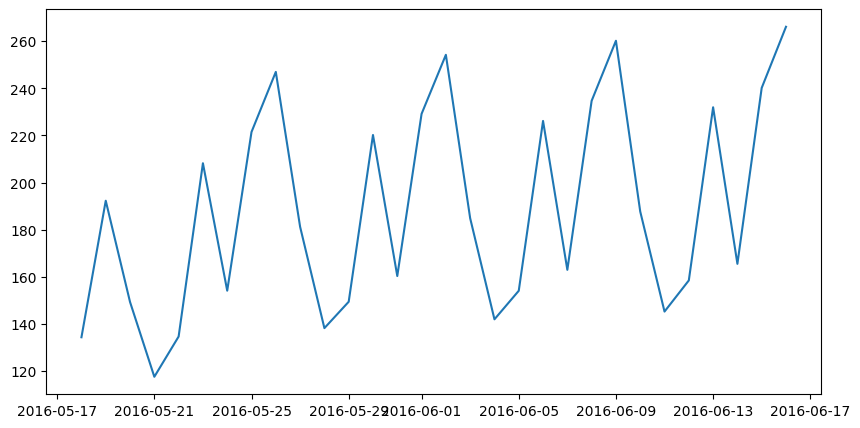

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.plot(
    results.forecast_timestamp,
    results.forecast_value,
)